In [8]:
# Importing packages
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import numpy as np
import itertools
from ipywidgets import Layout
import seaborn as sns
import math
from IPython.display import clear_output

import time
from scipy import linalg
import scipy.optimize as optimize
import sympy as sm

from tkinter import *
import tkinter as tk

from data_gen import gen_df 

from IPython.display import clear_output 


In this project, we want to try to estimate the ratings of movies. That is, we well calculate the utility of a movie, given genres, duration, awards and so forth, and we will try to calculate the IMDB ratings for each movie, based on this utility. Finally, we will then minimize the distance between our estimated ratings and the actual ratings. 

Our utility function is given by: 
$$ U_i = \sum_{k=1}^{23}(\alpha_k G_{ik}) + \sum_{k=1920}^{2010} (\beta_k D_{ik}) + \gamma N_i + \delta W_i + \rho_1 L_i + \rho_2 L_i^2 $$. 

Based on this utility function, we will estimate the ratings of each movies,
$$ R_i^{model} = \frac{\exp(\omega x_i)}{1 + \exp(\omega x_i)} $$ 

where, 
$$ x_i = \big[G_1, G_2, ..., G_n, D_{1920}, D_{1930}, ..., D_{2010}, N_i, W_i, L_i, L_i^2 \big] $$
$$ \omega = \big[\alpha_1, \alpha_2, ..., \alpha_{23}, \beta_{1920}, \beta_{1930}, ..., \beta_{2010}, \gamma, \delta, \rho_1, \rho_2  \big] $$

We then use optimize methods to solve the following: 

$$ \min_{\omega} \Big\{ \sum_{i=1}^{n} \left( R_i^{model} - R_i^{data} \right)^2 \Big\} $$


In [9]:
def df_s(keep_top=None):
    """ Prepares data for optimization by creating dummmy-variables for decades, dropping movies with less than 5000 ratings,
        dropping some variables that we don't wish to use in the model, and splitting the dataset, so we have a data set
        consisting only of the variables used in the model.
        
    Args:
        keep_top (optional, type: int): When a number (n) is put in this option, only the top n movies a kept in the dataset. This is used to sort out movies for a better fit of the model

    Returns:
        df_X (type: Pandas dataframe): A dataframe consisting only of the varaibles that are used to calculate the rating.
        df_Y (type: Pandas dataframe): A dataframe consisting the true rating from the dataset and an index-variable, used for merging with original dataset, later in the process.

    Notice:
        The function includes global for 'df', which means that the dataframe 'df' generated, can be called outside the function. This is used so that we won't have to filter the original dataframe again, when we use it again.
    """
    global df

    # Calls the file 'imdb.csv' which is located in the repository, and contains the dataset used
    filename = 'imdb.csv'

    # A function generated earlier, which cleans the dataset [Should we include this, and do some of the filtering below in that funciton?]
    df = gen_df(filename)

    # Generate list of decades for dummies
    decade_list = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]

    # Decade dummies
    for i in decade_list:
        df[f'decade_{i}'] = 0
        df.loc[(df['decade'] == f'{i}s'),f'decade_{i}'] = 1

    # Filters out movies with less than 5000 ratings and drops some genres
    df = df.loc[(df['ratingCount']>=5000)]
    df = df.drop(columns=['Adult','GameShow','News','RealityTV','TalkShow'])

    # Keeps only top n movies, if this is specified when calling the function
    if keep_top != None:
        df = df.sort_values('imdbRating', ascending=False)
        df = df.iloc[:keep_top]

    # Splits the dataset into two datasets
    df_X = df.copy()
    df_Y = pd.DataFrame(df[['imdbRating', 'index']].copy())
    df_Y = df_Y.rename(columns = {'imdbRating':'rat_data'})

    # Rearrange and keep given columns 
    df_X = df_X.reindex(['Action','Adventure','Animation','Biography','Comedy','Crime','Documentary',
                              'Drama','Family','Fantasy','FilmNoir','History','Horror','Music','Musical',
                              'Mystery','Romance','SciFi','Short','Sport','Thriller','War','Western',
                              'decade_1920','decade_1930','decade_1940','decade_1950','decade_1960',
                              'decade_1970','decade_1980','decade_1990','decade_2000','decade_2010',
                              'nrOfNominations','nrOfWins','duration'], axis=1)
    
    return df_X, df_Y

## Optimization
We analyze preferences for movies by minimizing the sum of the squared differences from our model prediction and the true rating, i.e.:
$$
\min_{\omega} (R_{model}-R_{data})^2
$$
By doing so, we'll find parameters that best describe movie preferences given our model. As we will discuss later, our model is not necessarily the best model to describe preferences, which might lead to these preferences not being completely true. <br>
If the model would predict all movie ratings correctly the parameters would perfectly describe movie preferences. For example if the parameter for action-movies were negative, the prediction would be precise, if action-movies generally had a negative impact on ratings. Of course people have much different preferences, and an interesting analysis would be, to predict preferences for different people, and by this look at a distribution of these parameters. This is not included in this project, though. <br>
To shorten the length of the optimizing process, and to sort out movies that makes it harder for the model to predict preferences, the optimization can be based on the top n movies, based on IMDb rating. When all movies are included in the optimizer the lowest ranking movies will have ratings around 2. Our rating predictor will in this case not rank any movies under 5. Thereby it is clear that the predictor model is not able to predict movies with very low rating. But it is able to predict movies with higher rating.

In [10]:
def optimizer(keep_top=None, live_graph=True):
    """ Creates and optimizes the function which calculates rating based on variables in the dataset.
    
    Args:
        keep_top (optional, type: int): When a number (n) is put in this option, only the top n movies a kept in the dataset. This is used to sort out movies for a better fit of the model
        live_graph(optional, type: boolean): Produces a live graph of the optimization proces, plotting the function values against the iterations. Makes the optimizer slower, but is a good visualization of the process.
                                             
    Returns:
        result (type: scipy optimizer object): An object containing results from the optimizer among other information such as status etc.
        timer (type: int): Time of running optimizer in seconds.
                                               
    Notice:
        Uses the package scipy.optimize.minimize which optimizes functions based on a given method. Here 'Nelder-Mead' is used.
        This function defines a set of functions used in the optimizer which are not documented by docstring bu comments in code.
    """
    # "Initializes" a timer for printing time of optimization
    start = time.time()
    
    # Set of globals so variables can be called inside the functions defined in this function
    global fs
    global evals
    global x0
    global df
    global df_Y
    
    # Calculates the sum of the squared differences between rating calculated by model and ratings from the dataset.
    # This is what is to be minimized
    def sqr_diff_sum(df_X,pars):
        global df_Y
        util = df_X@pars
        df_Y['rat_model'] = 10*np.exp(util)/(1+np.exp(util))
        df_Y['sqr_diff'] = (df_Y['rat_model']-df_Y['rat_data'])**2
        return df_Y['sqr_diff'].sum()

    # List of zeroes for initial guess
    def zeros(n): 
        list = [0] * n
        return list 
    
    # Plots a live graph of optimization process, if chosen.
    if live_graph:
        # The live plot is created by taking the function value for each iteration and saving in a list
        def live_plot(evals, fs, ymax=10000, figsize=(7,5)):
            # Clears plot every time a new plot is created
            clear_output(wait=True)
            plt.figure(figsize=figsize)

            # Plots values and sets title, grid, labels, etc.
            plt.plot(evals, fs)
            plt.title('Optimizing path')
            plt.grid(True)
            plt.xlabel('Iterations')
            plt.ylabel('Function value')
            plt.xlim(0,20000)
            plt.ylim(0,ymax)

            plt.show();

    # Function to be called by optimizer each iteration. This returns function values for each iteration and plots live graph
    def collect(x):
        # Set of globals to be called in live graph-function
        global fs
        global evals
        global x0
        global fig
        global ax
        global ymax

        # Calculates function value for initial guess, for first iteration
        if evals == 0:
            fs = []
            fs.append(obj_fun(x0))

        # Calculates function values for current parameter values
        if evals != 0:
            fs.append(obj_fun(x))
        
        # Plots live graph if chosen
        if live_graph:
            # Calculates max y-value for axis for first iteration
            if evals == 1:
                ymax = math.ceil(obj_fun(x)/2000)*2000

            # Updates plot every 100th iteration for the first 1000 iterations
            if evals < 1000:
                if evals > 0 and evals%100 == 0:
                    live_plot(range(evals+1), fs, ymax)
            # Updates plot every 500th iteration for the rest of the process
            if evals >=1000:
                if evals%500 == 0:
                    live_plot(range(evals+1), fs, ymax)
        
        # Adds one to the number of iterations each iteration
        evals += 1
    
        
    # Define datasets to be used using function defined earlier
    df_X, df_Y = df_s(keep_top=keep_top)
    
    # Intiial guess
    x0 = zeros(36)
    
    # Start iteration number
    evals = 0
    
    # Defines function to be minimized
    obj_fun = lambda x: sqr_diff_sum(df_X,x)
    
    # Run optimizer
    result = optimize.minimize(obj_fun,x0,
                               method="Nelder-Mead",
                               options={"disp":True, "maxiter":50000}, # display the results
                               callback=collect
                               ) 
    
    # End timer
    end = time.time()-start
    
    # Returns
    return result, end

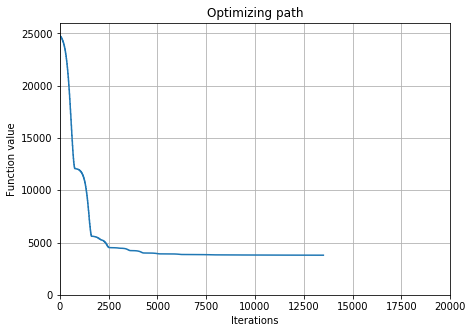

In [ ]:
# Run optimizer function and print results and time
result, timer = optimizer()
print(f'{" ":9s}Time: {timer:.4f} seconds')

# Create a dictionary of parameter results for each variable
variables = ['Action','Adventure','Animation','Biography','Comedy','Crime','Documentary',
            'Drama','Family','Fantasy','FilmNoir','History','Horror','Music','Musical',
            'Mystery','Romance','SciFi','Short','Sport','Thriller','War','Western',
            'decade_1920','decade_1930','decade_1940','decade_1950','decade_1960',
            'decade_1970','decade_1980','decade_1990','decade_2000','decade_2010',
            'nrOfNominations','nrOfWins','duration']

results = dict()


for j,i in enumerate(variables):
    results[i] = result.x[j]

## Prediction precision
Ideally our model would predict movie ratings perfectly, and thereby our parameters would perfectly describe the general preferences for movies. Whether this is possible, even with an advanced model, is not sure. People have different preferences, and two movies that would seem identical in our dataset, based on genres, duration, time of release, etc. could have very different ratings. Therefore som devitaion in our prediction from the true ratings are expected. <br>
The left graphs above plot the mean of deviations based on genres, duration, decades, and true ratings. The right graphs plot the number of movies in the dataset based on the same groups. From these graphs we see a clear correlation between precision and number of movies in the dataset. The more movies of a given genre, duration, etc. the more precise the prediction of movie-ratings in these groups. Take drama-movies as an example. The mean of the deviation is close to zero, and movies of this genre is also quite overrepresentated in the dataset. The complete opposite case is short-movies. But we also see that sci-fi-movies are quite well predicted, even though there aren't relatively many of these movies in the dataset. The same is seen in other different genres. <br>
This general image is seen when we group movies on decades, duration, and true rating as well.

In [11]:
def merge_df(df_org):
    """ Merges the original dataset with the optimal solution from the optimizer, i.e. the last dataset of calculated raitngs.
    
    Args:
        df_org (type: Pandas dataframe): The orignal dataset of movies, containing true ratings.
        
    Returns:
        df_merge (type: Pandas dataframe): Original dataset combined with calculated ratings from optimal parameters.
    """

    # Merges original dataset with optimal ratings based on model
    df_merge = df_org.merge(df_Y, how='right', left_on='index', right_on='index')

    # Calculates deviations both in normal and absolute form 
    df_merge['abs_diff'] = abs(df_merge['rat_model']-df_merge['rat_data'])
    df_merge['diff'] = df_merge['rat_model']-df_merge['rat_data']
    
    return df_merge


def _mean_genre(df,group):  
    """ Calculates the mean of deviations from true ratings and ratings based on optimal parameters from optimizer.
    
    Args:
        df (type: Pandas dataframe): Dataframe consisting information on groups and deivations
        group (type: string): Defines which group mean of deviations are presented for. Chosen by fixed list in widget.
        
    Returns:
        None
        
    Notice:
        Only to be run through widget.interact()
    """
    # List of values used for each group
    genre_list = ['Action','Adventure','Animation','Biography','Comedy','Crime','Documentary',
                    'Drama','Family','Fantasy','FilmNoir','History','Horror','Music','Musical',
                    'Mystery','Romance','SciFi','Short','Sport','Thriller','War','Western']
    
    decade_list = ['1920s', '1930s', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']
    
    dur_list = [0, .5, 1, 1.5, 2, 2.5, 3, 3.5]
    
    rat_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    
    mean_dict = dict()
    count_dict = dict()
    
    # Creates dictionaries based on chosen group
    if group == 'Genres':
        for i in genre_list:
            I = df[i] == 1
            mean_dict[i] = df.loc[I]['diff'].mean()
            count_dict[i] = df.loc[I]['index'].count()    

    if group == 'Decades':
        for i in decade_list:
            I = df['decade'] == i
            mean_dict[i] = df.loc[I]['diff'].mean()
            count_dict[i] = df.loc[I]['index'].count()

    if group == 'Duration':
        for j,i in enumerate(dur_list):
            if j != len(dur_list)-1:
                # Uses values from dict, to find movies between to items in the lists.
                I = ((df['duration'] >= dur_list[j]) & (df['duration'] < dur_list[j+1]))
                mean_dict[f'{dur_list[j]:2.1f} - {dur_list[j+1]:2.1f}'] = df.loc[I]['diff'].mean()
                count_dict[f'{dur_list[j]:2.1f} - {dur_list[j+1]:2.1f}'] = df.loc[I]['index'].count()
            else:
                I = df['duration'] >= dur_list[j]
                mean_dict[f'{dur_list[j]:2.1f} {"+":5s}'] = df.loc[I]['diff'].mean()
                count_dict[f'{dur_list[j]:2.1f} {"+":5s}'] = df.loc[I]['index'].count()

    if group == 'True rating':
        for j,i in enumerate(rat_list):
            if j != len(rat_list)-1:
                # Uses values from dict, to find movies between to items in the lists.
                I = ((df['rat_data'] >= rat_list[j]) & (df['rat_data'] < rat_list[j+1]))
                mean_dict[f'{rat_list[j]:4.1f} - {rat_list[j+1]:3.1f}'] = df.loc[I]['diff'].mean()
                count_dict[f'{rat_list[j]:4.1f} - {rat_list[j+1]:3.1f}'] = df.loc[I]['index'].count()
            else:
                pass
                           
    # Creates figure to hold two subplots 
    fig1, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(12,5))
                           
    # Plots means of deviations
    ax1.barh(*zip(*mean_dict.items()))
    ax1.set_ylabel(group)
    ax1.set_xlabel('Model deviation')
    ax1.grid(axis='x')
                           
    # Plots count of movies
    ax2.barh(*zip(*count_dict.items()))
    ax2.set_xlabel('Number of observations')
    ax2.grid(axis='x')
    
    
# Calls merge-function
df_merge = merge_df(df) 

# Runs interactive figure 
mean_genre = widgets.interact(_mean_genre, 
                             df = widgets.fixed(df_merge),
                             group = widgets.Dropdown(
                             options = ['Genres','Decades','Duration', 'True rating'],
                             description = 'Group',
                             value = 'Genres'))


interactive(children=(Dropdown(description='Group', options=('Genres', 'Decades', 'Duration', 'True rating'), …